# Difference Plots

Data Sources:   
WAOM:  
 - Richter, O., Gwyther, D. E., Galton-Fenzi, B. K., and Naughten, K. A.: The Whole Antarctic Ocean Model (WAOM v1.0): development and evaluation, Geosci. Model Dev., 15, 617–647, https://doi.org/10.5194/gmd-15-617-2022, 2022.

Grounding Line (2003):
 - Bindschadler, R., & Choi, H. (2011) "High-resolution Image-derived Grounding and Hydrostatic Lines for the Antarctic Ice Sheet" U.S. Antarctic Program (USAP) Data Center. doi: https://doi.org/10.7265/N56T0JK2.

Ice Front (2011):
 - Greene, C. A., A. S. Gardner, N.-J. Schlegel, and A. D. Fraser. 2024. MEaSUREs ITS_LIVE Antarctic
Annual 240 m Ice Sheet Extent Masks, 1997-2021, Version 1. [ice_mask]. Boulder,
Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center.
https://doi.org/10.5067/9ZFX84T5GI6D. [July 2025].



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import xarray as xr
import rasterio
from rasterio.transform import xy
from scipy.spatial.distance import pdist

In [4]:
# Preparing the z_rho for depth extraction

with rasterio.open("z_rho_3031.tif") as src:
    z_rho = src.read() 
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height

cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(transform, rows, cols)
X = np.array(xs)  
Y = np.array(ys)

In [6]:
# Preparing the NetCDF file for variable extraction

ds = xr.open_dataset("WAOM_Variables_3031.nc")
temperature = ds['temp_3031'].values  

## Difference Plots for Full Cross Sections

### Cross Section Visualisation

In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd 
from shapely.geometry import LineString

In [10]:
# Prepping data for plotting:

#xlimit = (1009812.2080419888952747, 1191254.7718926025554538)
xlimit = (998543, 1304094)
ylimit = (-2197135.0244829640723765, -2015411.0521906625945121)

tif_path = "CIS_BMR_mask_clipped.tif"
with rasterio.open(tif_path) as src:
    melt = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Convert from m/s to m/yr
s_per_yr = 365.25 * 24 * 60 * 60 
melt = melt * s_per_yr

# Applying the Gaussian smoothing
sigma = 1 
melt_smooth = gaussian_filter(np.nan_to_num(melt, nan=0.0), sigma=sigma)
melt_smooth[np.isnan(melt)] = np.nan

groundingline = gpd.read_file('2003_GL_full_cook_complete_dissolved_larger.shp')
coastline = gpd.read_file('ice_front_2011.shp')
cross_sections = gpd.read_file('cross_sections_3031_v3.shp')

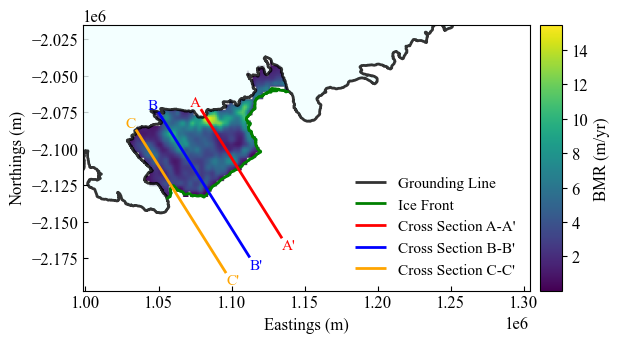

In [12]:
# Plotting the data

fig, ax = plt.subplots(figsize=(160/25.4, 100/25.4))  # mm to inches
img = ax.imshow(melt_smooth, cmap='viridis', origin='upper', extent=extent)

groundingline.plot(ax=ax, edgecolor='black', facecolor='azure', linewidth=2, label='Grounding Line', alpha=0.8)
coastline.plot(ax=ax, edgecolor='green', facecolor='none', linewidth=2, label='Ice Front')
#cross_sections.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, label='Cross Sections')

# CROSS SECTION linestring shapefile plotting:
colors = ['red', 'blue', 'orange']
labels = ["Cross Section A-A'", "Cross Section B-B'", "Cross Section C-C'"]
for i, (color, label) in enumerate(zip(colors, labels)):
    cross_sections.iloc[[i]].plot(
        ax=ax, edgecolor=color, facecolor='none', linewidth=2, label=label)
endpoint_labels = [("A", "A'"), ("B", "B'"), ("C", "C'")]
for i, (color, label, (label_start, label_end)) in enumerate(zip(colors, labels, endpoint_labels)):
    line = cross_sections.geometry.iloc[i]

    if line.geom_type == "MultiLineString":
        line = list(line.geoms)[0]
    x_start, y_start = line.coords[0]
    x_end, y_end = line.coords[-1]
    ax.text(x_start, y_start, label_start, fontsize=11, fontfamily='Times New Roman',
            color=color, verticalalignment='bottom', horizontalalignment='right')
    ax.text(x_end, y_end, label_end, fontsize=11, fontfamily='Times New Roman',
            color=color, verticalalignment='top', horizontalalignment='left')

# Rest of the plot:
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(img, cax=cax)
cbar.set_label("BMR (m/yr)", fontsize=12, fontfamily='Times New Roman')
for tick_label in cbar.ax.get_yticklabels():
    tick_label.set_fontsize(12)
    tick_label.set_family('Times New Roman')

ax.set_xlabel('Eastings (m)', fontsize=12, fontfamily='Times New Roman')
ax.set_ylabel('Northings (m)', fontsize=12, fontfamily='Times New Roman')
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)
    label.set_family('Times New Roman')

# Corrects font for the scaling factor
ax.xaxis.get_offset_text().set_fontsize(12)
ax.xaxis.get_offset_text().set_family('Times New Roman')
ax.yaxis.get_offset_text().set_fontsize(12)
ax.yaxis.get_offset_text().set_family('Times New Roman')

ax.tick_params(direction='in')
ax.set_xlim(xlimit)
ax.set_ylim(ylimit)
#ax.set_title("Gaussian Smoothed BMR (WAOM)", fontsize=12, fontfamily='Times New Roman')
ax.set_aspect('equal')

legend = ax.legend(loc='lower right', prop={'size': 11, 'family': 'Times New Roman'})
legend.get_frame().set_edgecolor('none')  # Removes the legend border

plt.tight_layout()
#plt.savefig('WAOM_Cross_Section_Cords.jpg', dpi=500, bbox_inches='tight')
plt.show()


### Data Prepping

Temp Section 1:

In [7]:
xmin, xmax = 1078998.1917, 1134587.8693
ymin, ymax = -2072930.4516, -2161360.5337
start_x, start_y = xmin, ymin
end_x, end_y = xmax, ymax
n_points = 300
x_line = np.linspace(start_x, end_x, n_points)
y_line = np.linspace(start_y, end_y, n_points)

In [ ]:
z_levels = temperature.shape[0]
temp_section_1 = np.zeros((z_levels, n_points))

for k in range(z_levels):
    temp_k = temperature[k, :, :] 
      
    points = np.column_stack((X.ravel(), Y.ravel()))
    temp_section_1[k, :] = griddata(points, temp_k.ravel(), (x_line, y_line), method='linear')

In [ ]:
np.save("temp_section_1.npy", temp_section_1)

In [14]:
temp_section_1 = np.load("temp_section_1.npy")

Temp Section 2:

In [ ]:
xmin, xmax = 1049863.9700000092852861, 1112546.3867892120033503  
ymin, ymax = -2074869.5600000144913793, -2174544.8276608600281179 
start_x, start_y = xmin, ymin
end_x, end_y = xmax, ymax
n_points = 300
x_line = np.linspace(start_x, end_x, n_points)
y_line = np.linspace(start_y, end_y, n_points)

In [ ]:
z_levels = temperature.shape[0]
temp_section_2 = np.zeros((z_levels, n_points))

for k in range(z_levels):
    temp_k = temperature[k, :, :] 
     
    points = np.column_stack((X.ravel(), Y.ravel()))
    temp_section_2[k, :] = griddata(points, temp_k.ravel(), (x_line, y_line), method='linear')

In [ ]:
np.save("temp_section_2.npy", temp_section_2)

In [16]:
temp_section_2 = np.load("temp_section_2.npy")

Temp Section 3:

In [ ]:
xmin, xmax = 1034534.06023618, 1096302.0333 
ymin, ymax = -2086972.74179876, -2185202.4510
start_x, start_y = xmin, ymin
end_x, end_y = xmax, ymax
n_points = 300
x_line = np.linspace(start_x, end_x, n_points)
y_line = np.linspace(start_y, end_y, n_points)

In [ ]:
z_levels = temperature.shape[0]
temp_section_3 = np.zeros((z_levels, n_points))

for k in range(z_levels):
    temp_k = temperature[k, :, :] 
    salt_k = salinity[k, :, :] 
    z_k = z_rho[k, :, :]         

    points = np.column_stack((X.ravel(), Y.ravel()))
    temp_section_3[k, :] = griddata(points, temp_k.ravel(), (x_line, y_line), method='linear')

In [ ]:
np.save("temp_section_3.npy", temp_section_3)

In [18]:
temp_section_3 = np.load("temp_section_3.npy")

### Difference Plot Comparing A-A' to B-B'

In [20]:
# Data preppin - flattening the 2D temperature values into a 1D shape
# I am using notations of 'g' and 'h' to not get confused with temp_sect 1 or 2, or cross sections A or B ordering systems
temp_g_values_1D = temp_section_1.flatten()
temp_h_values_1D = temp_section_2.flatten()

In [22]:
# Calculating the difference values - to be used as the y-axis
temp_g_h_difference = temp_g_values_1D - temp_h_values_1D
# Calculating the mean values - to be used as the x-axis
temp_g_h_mean = (temp_g_values_1D + temp_h_values_1D) / 2

mean_difference = np.mean(temp_g_h_difference)
sd_difference = np.std(temp_g_h_difference)
upper_lim = mean_difference + 1.96 * sd_difference
lower_lim = mean_difference - 1.96 * sd_difference

In [24]:
print('mean difference is equal to', mean_difference)
print('the lower confidence interval limit is', lower_lim)
print('the upper confidence interval limit is', upper_lim)

mean difference is equal to -0.05345627514860403
the lower confidence interval limit is -0.43974327469688657
the upper confidence interval limit is 0.33283072439967853


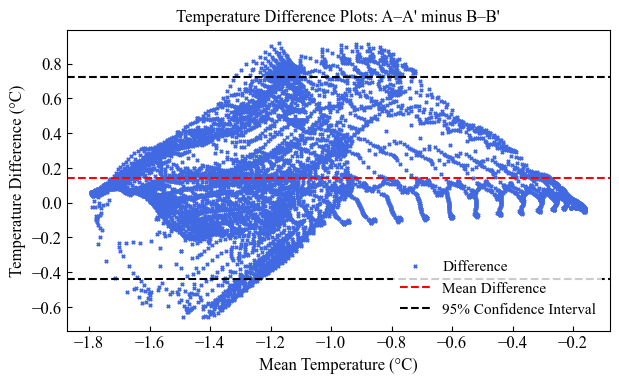

In [40]:
# Plotting the data

plt.figure(figsize=(160/25.4, 100/25.4))
plt.scatter(temp_g_h_mean, temp_g_h_difference, s=5, color='royalblue', label='Difference', marker='x')
plt.axhline(mean_difference, color='red', linestyle='--', label='Mean Difference')
plt.axhline(upper_lim, color='black', linestyle='--', label='95% Confidence Interval')
plt.axhline(lower_lim, color='black', linestyle='--')

plt.xlabel('Mean Temperature (°C)', fontsize=12, fontfamily='Times New Roman')
plt.ylabel('Temperature Difference (°C)', fontsize=12, fontfamily='Times New Roman')  
plt.title("Temperature Difference Plots: A–A' minus B–B'", fontsize=12, fontfamily='Times New Roman')
plt.tick_params(axis='x', labelsize=12, direction='in')  
plt.tick_params(axis='y', labelsize=12, direction='in') 

ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_fontsize(12)
    label.set_fontname('Times New Roman')
for label in ax.get_yticklabels():
    label.set_fontsize(12)
    label.set_fontname('Times New Roman')
    
legend = plt.legend(prop={'size': 11, 'family': 'Times New Roman'})
legend.get_frame().set_edgecolor('none')
legend.get_frame().set_facecolor('white')

plt.tight_layout()
#plt.savefig('Difference_Plot_A_B.jpg', dpi=500, bbox_inches='tight')
plt.show()


### Difference Plot Comparing A-A' to C-C'

In [34]:
# Data preppin - flattening the 2D temperature values into a 1D shape
# I am using notations of 'g' and 'h' to not get confused with temp_sect 1 or 2, or cross sections A or B ordering systems
temp_g_values_1D = temp_section_1.flatten()
temp_h_values_1D = temp_section_3.flatten()

In [36]:
# Calculating the difference values - to be used as the y-axis
temp_g_h_difference = temp_g_values_1D - temp_h_values_1D
# Calculating the mean values - to be used as the x-axis
temp_g_h_mean = (temp_g_values_1D + temp_h_values_1D) / 2

mean_difference = np.mean(temp_g_h_difference)
sd_difference = np.std(temp_g_h_difference)
upper_lim = mean_difference + 1.96 * sd_difference
lower_lim = mean_difference - 1.96 * sd_difference

In [38]:
print('mean difference is equal to', mean_difference)
print('the lower confidence interval limit is', lower_lim)
print('the upper confidence interval limit is', upper_lim)

mean difference is equal to 0.14144678806154037
the lower confidence interval limit is -0.439572787213762
the upper confidence interval limit is 0.7224663633368427


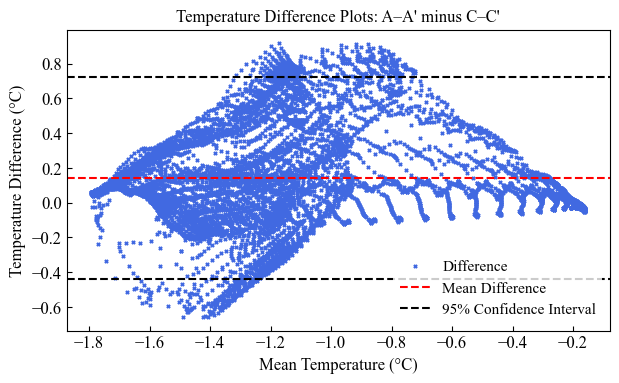

In [46]:
# Plotting the data

plt.figure(figsize=(160/25.4, 100/25.4))
plt.scatter(temp_g_h_mean, temp_g_h_difference, s=5, color='royalblue', label='Difference', marker='x')
plt.axhline(mean_difference, color='red', linestyle='--', label='Mean Difference')
plt.axhline(upper_lim, color='black', linestyle='--', label='95% Confidence Interval')
plt.axhline(lower_lim, color='black', linestyle='--')

plt.xlabel('Mean Temperature (°C)', fontsize=12, fontfamily='Times New Roman')
plt.ylabel('Temperature Difference (°C)', fontsize=12, fontfamily='Times New Roman')  
plt.title("Temperature Difference Plots: A–A' minus C–C'", fontsize=12, fontfamily='Times New Roman')
plt.tick_params(axis='x', labelsize=12, direction='in')  
plt.tick_params(axis='y', labelsize=12, direction='in') 

ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_fontsize(12)
    label.set_fontname('Times New Roman')
for label in ax.get_yticklabels():
    label.set_fontsize(12)
    label.set_fontname('Times New Roman')

legend = plt.legend(prop={'size': 11, 'family': 'Times New Roman'})
legend.get_frame().set_edgecolor('none')
legend.get_frame().set_facecolor('white')

plt.tight_layout()
#plt.savefig('Difference_Plot_A_C.jpg', dpi=500, bbox_inches='tight')
plt.show()


## Difference Plots for ONLY the CIS Portion of the Cross Sections

COPY FROM WAOM_3031 notebook